In [2]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

## basics

- $\theta$ 与 $\pi_\theta(s,a)$（给定 $\theta$（策略参数） 关于 s, a 的函数），基于 $\theta$ 找到 $\pi_\theta$
    - $\theta$ 是策略参数
    - $\pi_\theta(s,a)$ 是策略（base $\theta$，policy)
    - $\pi$ 表示 distribution
- 策略迭代（策略梯度，policy gradient）的含义
    - $\theta_0\rightarrow \pi_0$, $\theta_0 \rightarrow \theta_1$, $\theta_1 \rightarrow \pi_1$

## 更新 pi 的计算方式

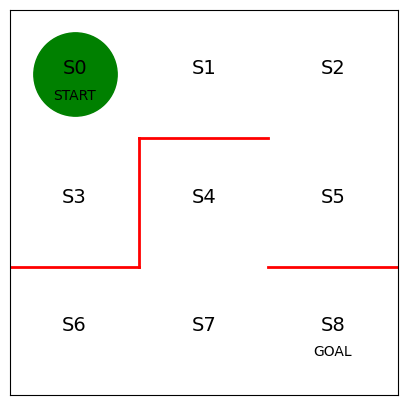

In [3]:
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)

# plt.plot([1, 1], [0, 1], color='red', linewidth=2)
# plt.plot([1, 2], [2, 2], color='red', linewidth=2)
# plt.plot([2, 2], [2, 1], color='red', linewidth=2)
# plt.plot([2, 3], [1, 1], color='red', linewidth=2)

plt.plot([2, 3], [1, 1], color='red', linewidth=2)
plt.plot([0, 1], [1, 1], color='red', linewidth=2)
plt.plot([1, 1], [1, 2], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)

plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')
# plt.axis('off')
plt.tick_params(axis='both', which='both', 
                bottom=False, top=False, 
                right=False, left=False,
                labelbottom=False, labelleft=False
               )
line, = ax.plot([0.5], [2.5], marker='o', color='g', markersize=60)

In [4]:
# border & barrier
# ↑, →, ↓, ←（顺时针）
# row index: given state
# col index: posible action
# (state, action) matrix
# 跟环境对齐
theta_0 = np.asarray([[np.nan, 1, 1, np.nan],      # s0
                      [np.nan, 1, np.nan, 1],      # s1
                      [np.nan, np.nan, 1, 1],      # s2
                      [1, np.nan, np.nan, np.nan], # s3 
                      [np.nan, 1, 1, np.nan],      # s4
                      [1, np.nan, np.nan, 1],      # s5
                      [np.nan, 1, np.nan, np.nan], # s6 
                      [1, 1, np.nan, 1]]           # s7
                     )

In [5]:
# 基于占比, 最 naive 的概率化方式
def cvt_theta_0_to_pi(theta):
    m, n = theta.shape
    pi = np.zeros((m, n))
    for r in range(m):
        pi[r, :] = theta[r, :] / np.nansum(theta[r, :])
    return np.nan_to_num(pi)

In [6]:
cvt_theta_0_to_pi(theta_0)

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        ],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.33333333, 0.33333333, 0.        , 0.33333333]])

$$
\begin{split}
\mathbb P_{k} & = \frac{\exp(z_k\cdot \beta)}{\sum_i \exp(z_i\cdot \beta)}\\
&=\frac{\exp(\frac{z_k}T)}{\sum_i \exp(\frac{z_i}T)}=\frac{\exp(\beta\cdot{z_k})}{\sum_i \exp(\beta\cdot{z_i})}
\end{split}
$$

In [13]:
# 基于 softmax，更 general 的概率化方式
def softmax_cvt_theta_0_to_pi(theta, beta=1.0):
    m, n = theta.shape
    pi = np.zeros((m, n))
    exp_theta = np.exp(theta*beta)
    for r in range(m):
        pi[r, :] = exp_theta[r, :]/np.nansum(exp_theta[r, :])
    pi = np.nan_to_num(pi)
    return pi

In [12]:
softmax_cvt_theta_0_to_pi(theta_0)

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        ],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.33333333, 0.33333333, 0.        , 0.33333333]])

## 与环境（Env）交互

In [15]:
# 维护着状态，以及 step 函数的返回
class MazeEnv(gym.Env):
    def __init__(self):
        self.state = 0
        pass
    
    def reset(self):
        self.state = 0
        return self.state
    
    def step(self, action):
        if action == 0:
            self.state -= 3
        elif action == 1:
            self.state += 1
        elif action == 2:
            self.state += 3
        elif action == 3:
            self.state -= 1
        done = False
        if self.state == 8:
            done = True
        # state, reward, done, _
        return self.state, 1, done, {}

$$
\begin{split}
&\theta_{s_i,a_j}=\theta_{s_i,a_j}+\eta\cdot \Delta \theta_{s,a_j}\\
&\Delta \theta_{s,a_j}=\frac{1}T\cdot \left(N(s_i,a_j) - P(s_i,a_j)N(s_i,a)\right)
\end{split}
$$

In [16]:
# 动作策略选择，基于当前环境的状态
class Agent:
    def __init__(self):
        self.actions = list(range(4))
        self.theta_0 = np.asarray([[np.nan, 1, 1, np.nan],      # s0
                      [np.nan, 1, np.nan, 1],      # s1
                      [np.nan, np.nan, 1, 1],      # s2
                      [1, np.nan, np.nan, np.nan], # s3 
                      [np.nan, 1, 1, np.nan],      # s4
                      [1, np.nan, np.nan, 1],      # s5
                      [np.nan, 1, np.nan, np.nan], # s6 
                      [1, 1, np.nan, 1]]           # s7
                     )
#         self.pi = self._cvt_theta_0_to_pi(self.theta_0)
        self.theta = self.theta_0
        self.pi = self._softmax_cvt_theta_to_pi()
        
        self.eta = 0.1
        
    def _cvt_theta_to_pi(self):
        m, n = self.theta.shape
        pi = np.zeros((m, n))
        for r in range(m):
            pi[r, :] = self.theta[r, :] / np.nansum(self.theta[r, :])
        return np.nan_to_num(pi)
    
    def _softmax_cvt_theta_to_pi(self, beta=1.):
        m, n = self.theta.shape
        pi = np.zeros((m, n))
        exp_theta = np.exp(self.theta*beta)
        for r in range(m):
            pi[r, :] = exp_theta[r, :] / np.nansum(exp_theta[r, :])
        return np.nan_to_num(pi)
    
    def update_theta(self, s_a_history):
        T = len(s_a_history) - 1
        m, n = self.theta.shape
        delta_theta = self.theta.copy()
        for i in range(m):
            for j in range(n):
                if not(np.isnan(self.theta_0[i, j])):
                    sa_i = [sa for sa in s_a_history if sa[0] == i]
                    sa_ij = [sa for sa in s_a_history if (sa[0] == i and sa[1] == j)]
                    N_i = len(sa_i)
                    N_ij = len(sa_ij)
                    delta_theta[i, j] = (N_ij - self.pi[i, j]*N_i)/T
        self.theta = self.theta + self.eta * delta_theta
        return self.theta
    
    def update_pi(self):
        self.pi = self._softmax_cvt_theta_to_pi()
        return self.pi
    
    def choose_action(self, state):
        # 依概率分布 \pi_\theta 选择 action
        action = np.random.choice(self.actions, p=self.pi[state, :])
        return action

In [17]:
env = MazeEnv()
agent = Agent()

In [18]:
state = env.state
# state, action
# trajectory
s_a_history = [[state, np.nan]]

In [19]:
while True:
    action = agent.choose_action(state)
    s_a_history[-1][1] = action
    state, reward, done, _ = env.step(action)
#     print(action, state, done)
    s_a_history.append([state, np.nan])
    if state == 8 or done:
        break

In [21]:
len(s_a_history)

301

## update $\theta$ and $\pi_\theta$ base policy gradient

- $\theta_{s_i, a_j} = \theta_{s_i, a_j} + \eta \Delta\theta_{s_i, a_j}$
- $\Delta\theta_{s_i, a_j}=\frac{N(s_i, a_j)-P(s_i,a_j)\cdot N(s_i, a)}{T}$

In [22]:
env = MazeEnv()
agent = Agent()
state = 0
# state, action
s_a_history = [[state, np.nan]]
while True:
    action = agent.choose_action(state)
    s_a_history[-1][1] = action
    state, reward, done, _ = env.step(action)
#     print(action, state, done)
    s_a_history.append([state, np.nan])
    if state == 8 or done:
        break

In [23]:
agent.update_theta(s_a_history)

array([[       nan, 1.00147059, 0.99852941,        nan],
       [       nan, 0.99852941,        nan, 1.00147059],
       [       nan,        nan, 1.        , 1.        ],
       [1.        ,        nan,        nan,        nan],
       [       nan, 1.00073529, 0.99926471,        nan],
       [1.        ,        nan,        nan, 1.        ],
       [       nan, 1.        ,        nan,        nan],
       [0.99901961, 0.99901961,        nan, 1.00196078]])

In [24]:
agent._softmax_cvt_theta_to_pi()

array([[0.        , 0.50073529, 0.49926471, 0.        ],
       [0.        , 0.49926471, 0.        , 0.50073529],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.50036765, 0.49963235, 0.        ],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.33300638, 0.33300638, 0.        , 0.33398725]])

## 完整训练及更新

In [25]:
stop_eps = 1e-4

In [26]:
agent = Agent()
env = MazeEnv()

while True:
    
    # 不断地从初始状态出发，产生一次 trajectory
    state = env.reset()
    # state, action
    s_a_history = [[state, np.nan]]
    while True:
        action = agent.choose_action(state)
        s_a_history[-1][1] = action
        state, reward, done, _ = env.step(action)
    #     print(action, state, done)
        s_a_history.append([state, np.nan])
        if state == 8 or done:
            break
            
    # 更新 theta
    agent.update_theta(s_a_history)
    pi = agent.pi.copy()
    # 更新 pi
    agent.update_pi()
    
    delta = np.sum(np.abs(agent.pi - pi))
    print(len(s_a_history), delta)
    if delta < stop_eps:
        break

47 0.005314357762166377
19 0.016354148141388747
65 0.010951055993865588
95 0.007476318058729836
101 0.004175798122291019
121 0.006138798222074082
77 0.011125850630924305
17 0.0260787192110859
31 0.012133554077081998
27 0.01036548373463031
37 0.012209640451421533
107 0.00870071517325599
19 0.019311588951356096
21 0.012532276657181152
23 0.015585603444688345
47 0.007802116021359773
73 0.009481963528227388
27 0.00951663025477023
15 0.014197156022299762
27 0.009581612620810143
27 0.016961544306114518
135 0.004994849618466302
77 0.011398631999796682
31 0.011376622749915244
19 0.021954478697300994
119 0.010647779350127673
13 0.024843755589004923
9 0.036665113204171595
41 0.006730438699212804
11 0.029207538812899114
23 0.013295460313497542
29 0.00664620569690344
15 0.042288406302036785
87 0.011457371953504158
121 0.006429246334040295
9 0.035546100906025446
41 0.006665196125037742
13 0.020417483977956785
25 0.011282797884012374
107 0.006883751991310916
45 0.012848332193748091
67 0.011166743820

In [27]:
agent.pi

array([[0.        , 0.98406185, 0.01593815, 0.        ],
       [0.        , 0.98815527, 0.        , 0.01184473],
       [0.        , 0.        , 0.9841382 , 0.0158618 ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.01666769, 0.98333231, 0.        ],
       [0.01400193, 0.        , 0.        , 0.98599807],
       [0.        , 1.        , 0.        , 0.        ],
       [0.0131148 , 0.97681357, 0.        , 0.01007163]])

In [28]:
env = MazeEnv()
state = env.reset()
# state, action
s_a_history = [[state, np.nan]]
while True:
    action = agent.choose_action(state)
    s_a_history[-1][1] = action
    state, reward, done, _ = env.step(action)
#     print(action, state, done)
    s_a_history.append([state, np.nan])
    if state == 8 or done:
        break

In [29]:
len(s_a_history)

7

In [30]:
from matplotlib import animation
from IPython.display import HTML

In [37]:
def init():
    line.set_data([], [])
    return (line, )
def animate(i):
    state = s_a_history[i][0]
    x = (state % 3)+0.5
    y = 2.5 - int(state/3)
    line.set_data([x], [y])

In [38]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(s_a_history), interval=200, repeat=False)

In [39]:
HTML(anim.to_jshtml())